
## StyleSwin pre-training on Trans-thalamus plane images


**Author(s):** Zhanxiang (Sean) Sun [@seansunn](https://github.com/seansunn)

**Contributor(s):** Harvey Mannering [@harveymannering](https://github.com/harveymannering) and Miguel Xochicale [@mxochicale](https://github.com/mxochicale)


### Introduction
This notebook presents implementation of StyleSwin GAN model on the datasets for this project.

### Running notebook
Go to repository path: `cd $HOME/repositories/budai4medtech/xfetus/examples`
Open repo in pycharm and in the terminal type:
```
git checkout master # or the branch
git pull # to bring a local branch up-to-date with its remote version
```
Launch Notebook server:
```
conda activate febusisVE
jupyter notebook --browser=firefox
```
which will open your web-browser.


### Logbook
* [DATE]: Short description of the update


### References

Bowen Zhang, Shuyang Gu, Bo Zhang, Jianmin Bao, Dong Chen, Fang Wen, Yong Wang, and Baining Guo. Styleswin: Transformer-based gan for high-resolution image generation. In *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, pages 11304–11314, June 2022.<br>
Official implementation: https://github.com/microsoft/StyleSwin<br>

Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han. Differentiable Augmentation for Data-Efficient GAN Training, June 2020.<br>
Official implementation: https://github.com/mit-han-lab/data-efficient-gans<br>

Liming Jiang, Bo Dai, Wayne Wu, and Chen Change Loy. Deceive D: Adaptive Pseudo Augmentation for GAN Training with Limited Data, 2021.<br>
Official implementation: https://github.com/EndlessSora/DeceiveD<br>



## 0. Setting imports and datasets paths


In [1]:
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.


import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance

from xfetus.styleswingan.dataset import getDataset, denormalize
from xfetus.styleswingan.diffaug import DiffAugment
from xfetus.styleswingan.generator import Generator
from xfetus.styleswingan.discriminator import Discriminator


HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/datasets/FETAL_PLANES_ZENODO/'
FULL_REPO_DATA_PATH = HOME_PATH+'/'+REPOSITORY_PATH

# Root directory for dataset
dataroot = FULL_REPO_DATA_PATH + "Images/"
ref = FULL_REPO_DATA_PATH + "FETAL_PLANES_DB_data.csv"



%matplotlib inline
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = 'data/saved_tt_256/'



## 1. Load datasets


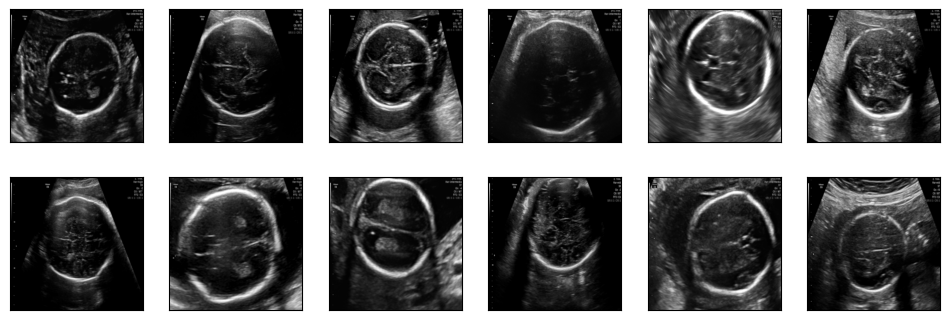

<Figure size 640x480 with 0 Axes>

In [2]:
# ['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular']
brain_plane = 'Trans-thalamic'
training_data = getDataset(brain_plane, data_path=dataroot, size=256, show_img=True)



In [3]:
# test_data = torch.load(f'data/images/test/{brain_plane}.pt', map_location=torch.device('cpu'))
test_data = torch.load(f'{brain_plane}.pt', map_location=torch.device('cpu'))
test_len = len(test_data)
test_len


215


## 2. Define loss


In [4]:
def discriminator_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)
    return real_loss.mean() + fake_loss.mean()


def generator_loss(fake_pred):
    return F.softplus(-fake_pred).mean()



## 3. Training loop setup



### 3.1 Initialize parameters for DiffAug and APA


In [5]:
# DiffAug policy
policy = "flip,color,translation"

# APA parameters
APA_p = 0.0
APA_threshold = 0.95
APA_speed = 1e-6
APA_update_step = 4
APA_start_epoch = 20
APA_max_prob = 0.6
lambda_r = 0.0



### 3.2 Setup training loop for one epoch


In [6]:
def generator_step(batch_size, latent_dim, policy=policy):
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    generator.train()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        fake_images = DiffAugment(generator(latent), policy=policy)
        d_fake = discriminator(fake_images)
        g_loss = generator_loss(d_fake)
    scaler.scale(g_loss).backward()
    scaler.step(g_optimizer)
    
    del fake_images
    
    return {'loss': g_loss}


def discriminator_step(batch_size, latent_dim, real_images, APA_p, policy=policy):
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        latent = torch.randn(batch_size, latent_dim).float().requires_grad_(False).to(device)
        real_images = DiffAugment(real_images, policy=policy)
        with torch.no_grad():
            generator.eval()
            fake_images = DiffAugment(generator(latent), policy=policy)

            # implement APA
            num_mix_fakes = (torch.rand(batch_size) < APA_p).sum().item()
            if num_mix_fakes > 0:
                mix_latent = torch.randn(num_mix_fakes, latent_dim).float().requires_grad_(False).to(device)
                mix_fake_images = generator(mix_latent)
                real_images = torch.cat([real_images[:(batch_size - num_mix_fakes)], mix_fake_images])

        d_real = discriminator(real_images)
        d_fake = discriminator(fake_images.detach())
        d_loss = discriminator_loss(d_real, d_fake)
        
    scaler.scale(d_loss).backward()
    scaler.step(d_optimizer)
    
    # update lambda_r for APA
    if (epoch + 1) % APA_update_step == 0 and epoch >= APA_start_epoch:
        lambda_rs = []

        for d_r in d_real[:(batch_size - num_mix_fakes)]:
            _lambda_r = d_r.sign().mean().item()
            lambda_rs.append(_lambda_r)

        if len(lambda_rs) != 0:
            lambda_r = sum(lambda_rs) / len(lambda_rs)
            APA_p += np.sign(lambda_r - APA_threshold) * APA_speed * batch_size * APA_update_step
            APA_p = np.clip(APA_p, 0., APA_max_prob)
            
    scaler.update()
    
    return {'loss': d_loss}, APA_p



## 4. Hyperparameters, initialization, and helper functions


In [11]:
latent_dim = 512


n_epochs = 2
# n_epochs = 500

# Hi Sean
#I tried to decrease batch size to avoid OOM but seems not working!
#Any other suggestions, then maybe gradient accumulation will be useful. Thanks, --Miguel
batch_size = 6
# batch_size = 12 # <OOM
# batch_size = 24 # <OOM

d_lr = 0.0002
g_lr = 0.00005
beta1 = 0.0
beta2 = 0.99

number_of_workers = 4


In [12]:


train_dataloader = DataLoader(training_data, batch_size, num_workers=number_of_workers, shuffle=True, drop_last=True)
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), d_lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(generator.parameters(), g_lr, [beta1, beta2])
#TOCHECK why is the reasong to choose 64?
fid = FrechetInceptionDistance(feature=64).to('cpu')
scaler = torch.cuda.amp.GradScaler()


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.79 GiB total capacity; 6.47 GiB already allocated; 512.00 KiB free; 6.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
def display(generated_images):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(6, 4))
    plot_size = 3
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(1, int(plot_size), idx+1, xticks=[], yticks=[])
        img = denormalize(generated_images[idx]).squeeze().detach().cpu().numpy()
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


def expand_channel(x):
    # repeats channel for 3 times
    return x.repeat(1, 3, 1, 1)



## 5. Train the model


In [10]:
fixed_latent_vector = torch.randn(3, latent_dim).float().to(device)
fixed_FID_vector = torch.randn(test_len, latent_dim).float().to(device)

losses = []
fids = []

discriminator.train()
generator.train()

for epoch in range(n_epochs):
    for i, real_images in enumerate(train_dataloader):
        real_images = real_images.to(device)

        d_loss, APA_p = discriminator_step(batch_size, latent_dim, real_images, APA_p)
        g_loss = generator_step(batch_size, latent_dim)

    d = d_loss['loss'].item()
    g = g_loss['loss'].item()
    losses.append((d, g))
    

    # print discriminator and generator loss
    print(f'Epoch [{epoch+1:3}/{n_epochs}] | D loss: {d:5.2f} | G loss: {g:5.2f} | P(apa): {APA_p:.2f}')
    
    if (epoch+1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            fid_img_list = []
            for i in range(test_len):
                fid_img = denormalize(generator(fixed_FID_vector[i].unsqueeze(0))).detach().cpu()
                fid_img_list.append(fid_img)

            fid_cat = torch.cat(fid_img_list)
            fid.update(test_data, real=True)
            fid.update(expand_channel(fid_cat), real=False)
            current_fid = fid.compute().item()
            fids.append(current_fid)
            fid.reset()
            
            # save checpoint
            torch.save(discriminator.state_dict(), checkpoint_path+f'd_{epoch+1:03}.pt')
            torch.save(generator.state_dict(), checkpoint_path+f'g_{epoch+1:03}.pt')
            print(f'Check point saved; FID: {current_fid:.2f}')

            # display images during training
            generated_images = generator(fixed_latent_vector)
            display(generated_images)
            del generated_images


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 7.79 GiB total capacity; 6.29 GiB already allocated; 26.50 MiB free; 6.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


## 6. Plot losses and FIDs



### 6.1 Training losses


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()



### 6.2 FIDs


In [ ]:
fig, ax = plt.subplots()
plt.plot(fids, label='FID', alpha=0.5)
plt.title("FID")
plt.legend()



### 6.3 Export logs


In [ ]:
import numpy as np


D_loss_log = losses.T[0]
G_loss_log = losses.T[1]
fid_log = np.array(fids)
np.save('logs/tt_500_D_loss_log.npy', D_loss_log)
np.save('logs/tt_500_G_loss_log.npy', G_loss_log)
np.save('logs/tt_500_FID_log.npy', fid_log)
